# Experimenting with (hopefully) fixed inputs

## ResNet-50

In [63]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import json
from PIL import Image
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import random

from sklearn.datasets import load_files   
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

C:\Users\Brian\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Loading and splitting data (from json)

In [4]:
with open('./Data/data_2.json', 'r', encoding='UTF-8') as f:
    data = json.load(f)

book_links = data['book_links']
shelf_links = data['shelves']
shelf_values = data['shelf_values']

In [5]:
with open('./Data/data_classes.json', 'r') as f:
    data = json.load(f)

files = []
classes = []

for i in range(len(data)):
    if data[i][1] > -1:
        files.append(data[i][0])
        classes.append(data[i][1])

In [6]:
directory = "./Data/data/images/"

In [7]:
dimensions = (200, 200)
num_classes = 5

In [8]:
shuffle_indices = shuffle(range(len(files)))
train_indices, test_indices = train_test_split(shuffle_indices, test_size=0.25)

In [21]:
X_train = []
y_train = []

for i in train_indices:
    filename = directory + str(i) + ".jpg"
    if os.path.isfile(filename):
        X_train.append(cv2.resize(cv2.imread(filename), dimensions, interpolation=cv2.INTER_LINEAR))
        y_train.append(classes[i])
        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []

for i in test_indices:
    filename = directory + str(i) + ".jpg"
    if os.path.isfile(filename):
        X_test.append(cv2.resize(cv2.imread(filename), dimensions, interpolation=cv2.INTER_LINEAR))
        y_test.append(classes[i])
        
X_test = np.array(X_test)
y_test = np.array(y_test)

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2466, 200, 200, 3), (2466,), (821, 200, 200, 3), (821,))

In [23]:
# Normalize image vectors
X_train = X_train/255.
X_test = X_test/255.

In [24]:
y_train[0:5], y_test[0:5], np.eye(num_classes)[y_train.reshape(-1)][0:5], np.eye(num_classes)[y_test.reshape(-1)][0:5]

(array([1, 1, 1, 0, 1]),
 array([1, 1, 1, 1, 1]),
 array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]))

### Loading and Splitting the Data (from Numpy)

## Normalized ResNet50

In [25]:
# Necessary for ResNet Dense Layer
y_train_norm = np.eye(num_classes)[y_train.reshape(-1)]
y_test_norm = np.eye(num_classes)[y_test.reshape(-1)]

In [26]:
# from keras_applications.resnet import ResNet50
# from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50

In [27]:
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = ResNet50(weights= None, include_top=False, input_shape=(dimensions[0], dimensions[1], 3))

In [28]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [29]:
from keras.optimizers import SGD, Adam
# sgd = SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
model.fit(X_train, y_train_norm, epochs=50, batch_size=64)

Epoch 1/50
39/39 [==============================] - 828s 21s/step - loss: 0.3308 - accuracy: 0.9124
Epoch 2/50
39/39 [==============================] - 795s 20s/step - loss: 0.4810 - accuracy: 0.8686
Epoch 3/50
39/39 [==============================] - 799s 20s/step - loss: 0.3624 - accuracy: 0.9165
Epoch 4/50
39/39 [==============================] - 799s 20s/step - loss: 0.2700 - accuracy: 0.9262
Epoch 5/50
39/39 [==============================] - 794s 20s/step - loss: 0.1947 - accuracy: 0.9444
Epoch 6/50
39/39 [==============================] - 800s 21s/step - loss: 0.2242 - accuracy: 0.9436
Epoch 7/50
39/39 [==============================] - 788s 20s/step - loss: 0.2460 - accuracy: 0.9384
Epoch 8/50
39/39 [==============================] - 791s 20s/step - loss: 0.2198 - accuracy: 0.9424
Epoch 9/50
39/39 [==============================] - 50560s 24s/step - loss: 0.1904 - accuracy: 0.9558
Epoch 10/50
39/39 [==============================] - 897s 23s/step - loss: 0.1939 - accuracy: 0.94

In [37]:
model.save('./ModelSaves/ResNet50v1_norm')

INFO:tensorflow:Assets written to: ./ModelSaves/ResNet50v1_norm\assets


INFO:tensorflow:Assets written to: ./ModelSaves/ResNet50v1_norm\assets


In [38]:
model.save('./ModelSaves/ResNet50v1_norm_h5', save_format='h5')

In [39]:
preds = model.evaluate(X_test, y_test_norm)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

26/26 [==============================] - 60s 2s/step - loss: 3.4942 - accuracy: 0.6212
Loss = 3.4941563606262207
Test Accuracy = 0.6211936473846436


In [40]:
preds = model(X_test)

In [41]:
preds[0:5]

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[4.9828210e-05, 9.9946386e-01, 4.8031597e-04, 5.0824915e-06,
        8.0543020e-07],
       [6.4648574e-08, 9.9794835e-01, 2.0511877e-03, 3.7568270e-07,
        2.1741345e-08],
       [1.4565419e-05, 9.9929786e-01, 6.3705503e-04, 4.9076836e-05,
        1.4830425e-06],
       [9.4674921e-22, 1.0000000e+00, 9.6931805e-09, 8.6319132e-26,
        2.8499191e-23],
       [1.9418389e-03, 6.7938042e-01, 3.1849346e-01, 1.8222370e-04,
        2.1001440e-06]], dtype=float32)>

In [43]:
np.sum(np.argmax(preds, axis=1) == np.argmax(y_test_norm, axis=1)) / len(y_test)

0.6211936662606578

In [44]:
np.unique(np.argmax(preds, axis=1), return_counts=True)

(array([0, 1, 2, 4], dtype=int64), array([  6, 694, 120,   1], dtype=int64))

3
/book/show/22896.Practical_Magic


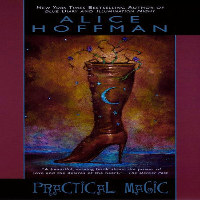

Sadness


C:\Users\Brian\AppData\Local\Temp\ipykernel_19548\3762500981.py:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im.thumbnail(dimensions, Image.ANTIALIAS)


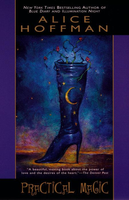

Sadness
/book/show/43369.God_Is_Not_Great


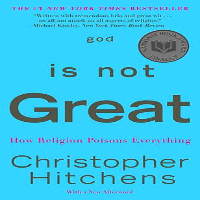

Sadness


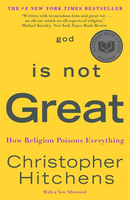

Sadness
/book/show/3257136-dewey


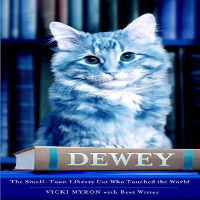

Sadness


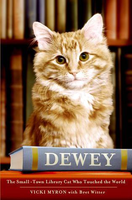

Fear
/book/show/7129598-nevermore


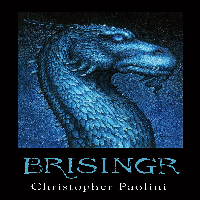

Sadness


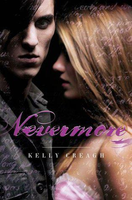

Anger
/book/show/23225.Haunted


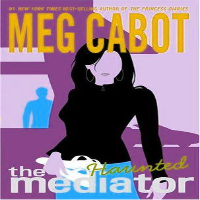

Sadness


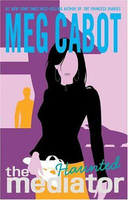

Disgust


IndexError: list index out of range

In [50]:
emotions = ["Happiness", "Sadness", "Fear", "Disgust", "Anger", "Surprise"]

emotion_presence = set()

rands = []

shuffle_indices = shuffle(range(len(preds)))

for i in shuffle_indices:
    if emotions[classes[i]] not in emotion_presence and np.argmax(preds[i]) == classes[i]:
        rands.append(i)
        emotion_presence.add(emotions[classes[i]])

print(len(rands))

while len(rands) < 5:
    pos = random.randint(0, len(test_indices) - 1)
    if emotions[classes[test_indices[pos]]] not in emotion_presence:
        rands.append(pos)
        emotion_presence.add(emotions[classes[test_indices[pos]]])

actuals = [test_indices[pos] for pos in rands]

for i in range(len(preds)):
    print('========================================================')
    print(book_links[actuals[i]])
    display(Image.fromarray((X_test[rands[i]] * 255).astype(np.uint8)))
    print(emotions[np.argmax(preds[i])])
    im = Image.open(directory + str(actuals[i]) + ".jpg")
    im.thumbnail(dimensions, Image.ANTIALIAS)
    display(im)
    print(emotions[classes[actuals[i]]])
    print('========================================================')

In [56]:
scores = {}
for i in range(len(y_test)):
    real_class = y_test[i]
    pred_class = np.argmax(preds[i])
    if real_class in scores:
        scores[real_class] = [scores[real_class][0] + int(real_class == pred_class), scores[real_class][1] + 1]
    else:
        scores[real_class] = [int(real_class == pred_class), 1]

In [57]:
for key in list(scores.keys()):
    print(key, scores[key], scores[key][0] / scores[key][1])

1 [477, 562] 0.8487544483985765
2 [33, 187] 0.17647058823529413
0 [0, 57] 0.0
3 [0, 11] 0.0
4 [0, 4] 0.0


## Normalized ResNet50 with Focus

In [58]:
# Necessary for ResNet Dense Layer
y_train_norm = np.eye(num_classes)[y_train.reshape(-1)]
y_test_norm = np.eye(num_classes)[y_test.reshape(-1)]

In [59]:
# from keras_applications.resnet import ResNet50
# from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50

In [60]:
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = ResNet50(weights= None, include_top=False, input_shape=(dimensions[0], dimensions[1], 3))

In [61]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [64]:
from keras.optimizers import SGD, Adam
# sgd = SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=SigmoidFocalCrossEntropy(), metrics=['accuracy'])

In [65]:
model.fit(X_train, y_train_norm, epochs=50, batch_size=64)

Epoch 1/50
39/39 [==============================] - 884s 22s/step - loss: 0.8756 - accuracy: 0.4643
Epoch 2/50
39/39 [==============================] - 824s 21s/step - loss: 0.6665 - accuracy: 0.4959
Epoch 3/50
39/39 [==============================] - 810s 21s/step - loss: 0.5907 - accuracy: 0.4753
Epoch 4/50
39/39 [==============================] - 858s 22s/step - loss: 0.4852 - accuracy: 0.5284
Epoch 5/50
39/39 [==============================] - 815s 21s/step - loss: 0.3781 - accuracy: 0.5612
Epoch 6/50
39/39 [==============================] - 810s 21s/step - loss: 0.3322 - accuracy: 0.5580
Epoch 7/50
39/39 [==============================] - 803s 21s/step - loss: 0.3382 - accuracy: 0.5839
Epoch 8/50
39/39 [==============================] - 803s 21s/step - loss: 0.3152 - accuracy: 0.5900
Epoch 9/50
39/39 [==============================] - 833s 21s/step - loss: 0.2673 - accuracy: 0.6127
Epoch 10/50
39/39 [==============================] - 809s 21s/step - loss: 0.2931 - accuracy: 0.6208

In [66]:
model.save('./ModelSaves/ResNet50v1_norm_focal')

INFO:tensorflow:Assets written to: ./ModelSaves/ResNet50v1_norm_focal\assets


INFO:tensorflow:Assets written to: ./ModelSaves/ResNet50v1_norm_focal\assets


In [67]:
preds = model.evaluate(X_test, y_test_norm)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

26/26 [==============================] - 61s 2s/step - loss: 0.2449 - accuracy: 0.6504
Loss = 0.24491138756275177
Test Accuracy = 0.6504263281822205


In [68]:
preds = model(X_test)

In [69]:
preds[0:5]

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0.08087289, 0.79361606, 0.07663284, 0.02442971, 0.02444849],
       [0.19429742, 0.3820636 , 0.313102  , 0.05282951, 0.05770747],
       [0.16277824, 0.5352208 , 0.20856251, 0.04144781, 0.0519906 ],
       [0.14753385, 0.59104234, 0.18153633, 0.04026369, 0.03962382],
       [0.12479767, 0.6602719 , 0.14401318, 0.03847314, 0.03244411]],
      dtype=float32)>

In [70]:
np.sum(np.argmax(preds, axis=1) == np.argmax(y_test_norm, axis=1)) / len(y_test)

0.6504263093788063

In [71]:
np.unique(np.argmax(preds, axis=1), return_counts=True)

(array([1, 2], dtype=int64), array([764,  57], dtype=int64))

2
/book/show/6065215-the-strain


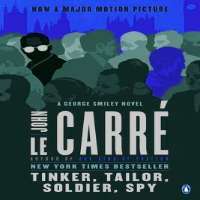

Sadness


C:\Users\Brian\AppData\Local\Temp\ipykernel_19548\3762500981.py:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im.thumbnail(dimensions, Image.ANTIALIAS)


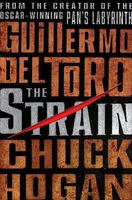

Fear
/book/show/19089.Middlemarch


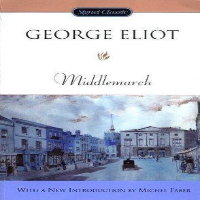

Sadness


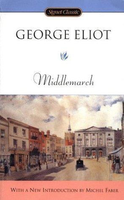

Sadness
/book/show/61346208-time-chain


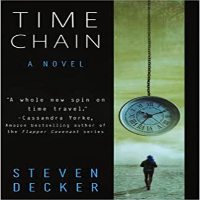

Sadness


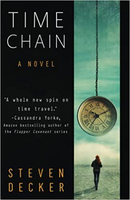

Happiness
/book/show/68427.Elantris


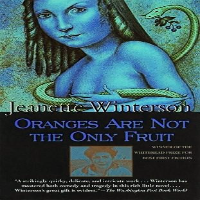

Sadness


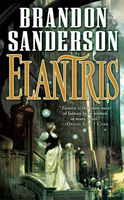

Disgust
/book/show/15724396-the-sword-of-summer


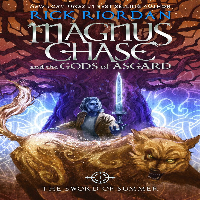

Sadness


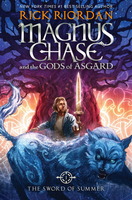

Anger


IndexError: list index out of range

In [72]:
emotions = ["Happiness", "Sadness", "Fear", "Disgust", "Anger", "Surprise"]

emotion_presence = set()

rands = []

shuffle_indices = shuffle(range(len(preds)))

for i in shuffle_indices:
    if emotions[classes[i]] not in emotion_presence and np.argmax(preds[i]) == classes[i]:
        rands.append(i)
        emotion_presence.add(emotions[classes[i]])

print(len(rands))

while len(rands) < 5:
    pos = random.randint(0, len(test_indices) - 1)
    if emotions[classes[test_indices[pos]]] not in emotion_presence:
        rands.append(pos)
        emotion_presence.add(emotions[classes[test_indices[pos]]])

actuals = [test_indices[pos] for pos in rands]

for i in range(len(preds)):
    print('========================================================')
    print(book_links[actuals[i]])
    display(Image.fromarray((X_test[rands[i]] * 255).astype(np.uint8)))
    print(emotions[np.argmax(preds[i])])
    im = Image.open(directory + str(actuals[i]) + ".jpg")
    im.thumbnail(dimensions, Image.ANTIALIAS)
    display(im)
    print(emotions[classes[actuals[i]]])
    print('========================================================')

In [73]:
scores = {}
for i in range(len(y_test)):
    real_class = y_test[i]
    pred_class = np.argmax(preds[i])
    if real_class in scores:
        scores[real_class] = [scores[real_class][0] + int(real_class == pred_class), scores[real_class][1] + 1]
    else:
        scores[real_class] = [int(real_class == pred_class), 1]

In [74]:
for key in list(scores.keys()):
    print(key, scores[key], scores[key][0] / scores[key][1])

1 [522, 562] 0.9288256227758007
2 [12, 187] 0.06417112299465241
0 [0, 57] 0.0
3 [0, 11] 0.0
4 [0, 4] 0.0
